In [2]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # find automatically the path of the folder containing "file_name" :
    file_name = 'data_test_demo.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    # if previous search failed or too long, comment the previous line and simply write down manually the path below :
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd
    

Mounted at /content/gdrive
./gdrive/MyDrive/CV Project/
/content/gdrive/MyDrive/CV Project


In [3]:
import pandas as pd
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import utils

In [4]:
df = pd.read_csv("A_Z Handwritten Data.csv")
device = torch.device("cuda")

4
4
4
4
4
4
4
4
4


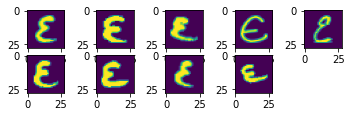

In [5]:
for i in range(1, 10):
    print(df.iloc[60000 + i, 0])
    plt.subplot(5, 5, i)
    digit = np.array(df.iloc[60000 + i, 1:])
    plt.imshow(digit.reshape(28, 28))

In [6]:
data_feature, data_label = np.array(df.iloc[:, 1:]), np.array(df.iloc[:, 0])
train_data, test_data, train_label, test_label = model_selection.train_test_split(
    data_feature, data_label, test_size=0.05, random_state=75)
ss = MinMaxScaler()
train_data = ss.fit_transform(train_data)
test_data = ss.fit_transform(test_data)

train_data = (torch.Tensor(train_data.reshape(-1,28,28))).cuda()
test_data = (torch.Tensor(test_data.reshape(-1,28,28))).cuda()
train_label = torch.LongTensor(train_label)
test_label = torch.LongTensor(test_label)

In [7]:
mean= train_data.mean()
std= train_data.std()

In [8]:
class two_layer_net(nn.Module):
    def __init__(self):
        super(two_layer_net, self).__init__()

        
        self.conv1 = nn.Conv2d(1,   26,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14 
        self.conv2 = nn.Conv2d(26,  50,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 7 x 7 = 4900 -->  100 
        self.linear1 = nn.Linear(2450, 50)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(50,26)


    def forward(self, x):

        # CL1:   28 x 28  -->    50 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        x = self.pool2(x)

        # LL1:   100 x 7 x 7 = 4900  -->  100 
        x = x.view(-1, 2450)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:   4900  -->  10 
        x = self.linear2(x)
    
        return x
       

In [9]:
net = two_layer_net()
net = net.cuda()
mean=mean.cuda()

std=std.cuda()
print(net)


two_layer_net(
  (conv1): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(26, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2450, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=26, bias=True)
)


In [10]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

bs = 10000

In [11]:
def eval_on_test_set():
    bs=1000
    running_error = 0
    num_batches = 0

    for i in range(0, 18000, bs):

        minibatch_data =  test_data[i:i+bs].unsqueeze(dim=1)
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.cuda()
        minibatch_label=minibatch_label.cuda()
        
        inputs = (minibatch_data - mean)/std

        scores = net(inputs)

        error = utils.get_error(scores, minibatch_label)

        running_error += error.item()

        num_batches += 1

    total_error = running_error / num_batches
    print('test error  = ', total_error * 100, 'percent')

In [12]:
start = time.time()

for epoch in range(100):

    running_loss = 0
    running_error = 0
    num_batches = 0

    shuffled_indices = torch.randperm(350000)

    for count in range(0, 350000, bs):

        # forward and backward pass

        optimizer.zero_grad()

        indices = shuffled_indices[count:count + bs]
        minibatch_data =  train_data[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.cuda()
        minibatch_label=minibatch_label.cuda()

        inputs = (minibatch_data - mean)/std

        inputs.requires_grad_()

        scores = net(inputs)

        loss = criterion(scores, minibatch_label)

        loss.backward()

        optimizer.step()

        # compute some stats

        running_loss += loss.detach().item()

        error = utils.get_error(scores.detach(), minibatch_label)
        running_error += error.item()

        num_batches += 1

    # once the epoch is finished we divide the "running quantities"
    # by the number of batches

    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed_time = time.time() - start

    # every 10 epoch we display the stats
    # and compute the error rate on the test set

    if epoch % 10 == 0:

        print(' ')

        print('epoch=', epoch, '\t time=', elapsed_time, '\t loss=',
              total_loss, '\t error=', total_error * 100, 'percent')

        eval_on_test_set()

 
epoch= 0 	 time= 6.3753767013549805 	 loss= 2.59702205657959 	 error= 72.64685835157123 percent
test error  =  73.08888832728067 percent
 
epoch= 10 	 time= 70.00223398208618 	 loss= 0.20113699563911983 	 error= 5.61143125806536 percent
test error  =  4.333329200744629 percent
 
epoch= 20 	 time= 135.8818941116333 	 loss= 0.10946064676557268 	 error= 3.004859685897827 percent
test error  =  2.8555505805545383 percent
 
epoch= 30 	 time= 201.6516935825348 	 loss= 1.0231153364692416 	 error= 17.652001891817363 percent
test error  =  36.28888626893361 percent
 
epoch= 40 	 time= 267.2070393562317 	 loss= 0.12761947278465544 	 error= 3.5062880175454274 percent
test error  =  3.3499949508243136 percent
 
epoch= 50 	 time= 332.79876732826233 	 loss= 0.08722151411431177 	 error= 2.374858856201172 percent
test error  =  2.3888832992977567 percent
 
epoch= 60 	 time= 398.5100667476654 	 loss= 0.07473063170909881 	 error= 2.0234312329973494 percent
test error  =  2.3111058606041803 percent
 
e

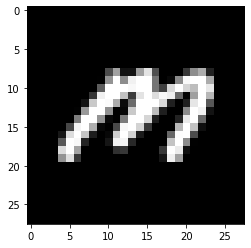

RuntimeError: ignored

In [19]:
# choose a picture at random
idx=np.random.randint(0, 18000)
im=test_data[idx]

# diplay the picture
utils.show(im.cpu())

# feed it to the net and display the confidence scores
scores =  net( im.view(1,784)) 
probs= F.softmax(scores, dim=1)
# utils.show_prob_mnist(probs)

# alphabets table
alphabets=[chr(i) for i in range(97,123)]
print(alphabets[probs.argmax()])